In [1]:
import nmslib
from nltk.stem import PorterStemmer
import string
import re
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.cluster import KMeans

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

sns.set_context('notebook')
sns.set_style('white')

In [2]:
df1 = pd.read_csv('course-catalog.csv')
df1.head(2)

,Year,Term,YearTerm,Subject,Number,Name,Description,Credit Hours,Section Info,Degree Attributes,...,Section Status,Enrollment Status,Type,Type Code,Start Time,End Time,Days of Week,Room,Building,Instructors
0,2022,Fall,2022-fa,AAS,100,Intro Asian American Studies,Interdisciplinary introduction to the basic co...,3 hours.,NaN,"Social & Beh Sci - Soc Sci, and Cultural Studi...",...,A,Open,Discussion/Recitation,DIS,09:00 AM,09:50 AM,F,313,Davenport Hall,"Lee, S;Zheng, R"
1,2022,Fall,2022-fa,AAS,100,Intro Asian American Studies,Interdisciplinary introduction to the basic co...,3 hours.,NaN,"Social & Beh Sci - Soc Sci, and Cultural Studi...",...,A,Closed,Discussion/Recitation,DIS,10:00 AM,10:50 AM,F,313,Davenport Hall,"Lee, S;Zheng, R"


In [3]:
df1 = pd.read_csv('course-catalog.csv')
print('==> List of all columns: \n\n',list(df1),'\n')

# sort data by names and subset data
df1 = df1.sort_values(by='Name')

# lets drop the duplicated data point in the description
df1 = df1.drop_duplicates(subset='Description', keep="first")

# select columns the we are interested
df1 = df1[['Subject','Name','Description']]
df1.head()

==> List of all columns: 

 ['Year', 'Term', 'YearTerm', 'Subject', 'Number', 'Name', 'Description', 'Credit Hours', 'Section Info', 'Degree Attributes', 'Schedule Information', 'CRN', 'Section', 'Status Code', 'Part of Term', 'Section Title', 'Section Credit Hours', 'Section Status', 'Enrollment Status', 'Type', 'Type Code', 'Start Time', 'End Time', 'Days of Week', 'Room', 'Building', 'Instructors'] 



,Subject,Name,Description
5926,GER,1920s to Today,"Literary, thematic, cultural, and bibliographi..."
6324,HIST,19thC Romanticism &amp; Politics,Among the topics of this course will be Romant...
11832,SPAN,20th-21stC Spanish Studies,Examines the cultural production of 20th and 2...
5934,GER,20thC German Studies,"Seminar in selected genres, themes, or authors..."
6309,HIST,20thC World to Midcentury,"Economic, social, political, and cultural deve..."


In [4]:
# creating the main dataset
data = df1.reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4412 entries, 0 to 4411
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Subject      4412 non-null   object
 1   Name         4412 non-null   object
 2   Description  4411 non-null   object
dtypes: object(3)
memory usage: 103.5+ KB


In [5]:
# show the all subject in the data
len(data['Subject'].unique())

190

In [6]:
# counting the datapoints for each group of subject 
keep=data.groupby('Subject').count().sort_values(by='Name',ascending=False)
print(' ==> list of Subject and their counts:', keep)

# keep only first 20 most frequent
keep=keep[:20].index
print('\n ==> List of Subject to keep: \n\n', keep)

 ==> list of Subject and their counts:          Name  Description
Subject                   
MUSC      138          138
MUS       107          107
ECE       100          100
IS         95           95
CS         87           87
...       ...          ...
GMC         1            1
CZCH        1            1
BASQ        1            1
CIC         1            1
HRD         1            1

[190 rows x 2 columns]

 ==> List of Subject to keep: 

 Index(['MUSC', 'MUS', 'ECE', 'IS', 'CS', 'THEA', 'BADM', 'CLE', 'PSYC', 'MATH',
       'FIN', 'ENGL', 'CHEM', 'FSHN', 'CEE', 'CHLH', 'KIN', 'PS', 'RST',
       'ANTH'],
      dtype='object', name='Subject')


In [7]:
data = data[data['Subject'].isin(keep)]
data = data.reset_index(drop=True)
data.shape

(1476, 3)

In [8]:
# selecting the column that has text
text = data['Description']

# removing null values
text = text[~pd.isnull(text)] #removing missing values

# preprocessing
text=text.tolist()
text[:3]

['Isomorphism theorems for groups. Group actions. Composition series. Jordan-Holder theorem. Solvable and nilpotent groups. Field extensions. Algebraic and transcendental extensions. Algebraic closures. Fundamental theorem of Galois theory, and applications. Modules over commutative rings. Structure of finitely generated modules over a principal ideal domain. Applications to finite Abelian groups and matrix canonical forms. Prerequisite: MATH 417 and MATH 418.',
 'Rigorous proof-oriented course in linear algebra. Topics include determinants, vector spaces over fields, linear transformations, inner product spaces, eigenvectors and eigenvalues, Hermitian matrices, Jordan Normal Form. 3 or 4 undergraduate hours. 3 or 4 graduate hours. Credit is not given for both MATH 416 and either ASRM 406 or MATH 415. 4 hours of credit requires approval of the instructor and department with completion of additional work of substance. Prerequisite: MATH 241 or consent of instructor; MATH 347 is recommen

In [9]:
# make it lower case
text = [t.lower() for t in text]
text[:3]

# Strip all punctuation from each article
# This uses str.translate to map all punctuation to the empty string
table = str.maketrans('', '', string.punctuation)
text = [t.translate(table) for t in text]

# Convert all numbers in the article to the word 'num' using regular expressions
text = [re.sub(r'\d+', 'num', t) for t in text]
# Print the first article as a running example
text[:2]

['isomorphism theorems for groups group actions composition series jordanholder theorem solvable and nilpotent groups field extensions algebraic and transcendental extensions algebraic closures fundamental theorem of galois theory and applications modules over commutative rings structure of finitely generated modules over a principal ideal domain applications to finite abelian groups and matrix canonical forms prerequisite math num and math num',
 'rigorous prooforiented course in linear algebra topics include determinants vector spaces over fields linear transformations inner product spaces eigenvectors and eigenvalues hermitian matrices jordan normal form num or num undergraduate hours num or num graduate hours credit is not given for both math num and either asrm num or math num num hours of credit requires approval of the instructor and department with completion of additional work of substance prerequisite math num or consent of instructor math num is recommended']

In [10]:
# stemming using PorterStemmer
#from nltk.stem import PorterStemmer

# creating stemmer model and fit evey sentence to it
stemmer = PorterStemmer()
text_stem = [stemmer.stem(t) for t in text]

In [11]:
# Import nltk, and WordNetLemmatizer
#import nltk
#from nltk.stem import WordNetLemmatizer

# for lemmatization, you need to download "wordnet" repository which contains family of words
nltk.download("wordnet")

# create lemmatizer and apply it for every sentence in the text
lem = nltk.stem.wordnet.WordNetLemmatizer()
text_lem = [lem.lemmatize(t) for t in text_stem]
text_lem[:3]

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aruna\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['isomorphism theorems for groups group actions composition series jordanholder theorem solvable and nilpotent groups field extensions algebraic and transcendental extensions algebraic closures fundamental theorem of galois theory and applications modules over commutative rings structure of finitely generated modules over a principal ideal domain applications to finite abelian groups and matrix canonical forms prerequisite math num and math num',
 'rigorous prooforiented course in linear algebra topics include determinants vector spaces over fields linear transformations inner product spaces eigenvectors and eigenvalues hermitian matrices jordan normal form num or num undergraduate hours num or num graduate hours credit is not given for both math num and either asrm num or math num num hours of credit requires approval of the instructor and department with completion of additional work of substance prerequisite math num or consent of instructor math num is recommend',
 'lectures and di

In [12]:
from sentence_transformers import SentenceTransformer
from sentence_transformers import util
model_SBERT = SentenceTransformer('all-MiniLM-L6-v2')

In [13]:
# this method encode the sentences into numpy vectors which can be used for clustering task
# the vectorization may take time
embeddings = model_SBERT.encode(text_lem, convert_to_numpy=True,show_progress_bar=True,batch_size=100) # By default, convert_to_numpy = True
embeddings.shape

Batches: 100%|██████████| 15/15 [00:27<00:00,  1.83s/it]


(1476, 384)

In [14]:
#We check that each generated note embedding has length 384.

# quick look to see how it looks like
print(embeddings[0][:50])

[-0.05439125 -0.05611386 -0.00766118  0.02458507 -0.05390879  0.05349702
  0.03884917 -0.05550802  0.02624939 -0.06594931  0.07264098  0.0174734
 -0.02111334 -0.05083277  0.0168073   0.03915076 -0.07581125  0.05780488
 -0.04076368 -0.02741104  0.02231018  0.01286341 -0.04854948  0.04025704
 -0.04496966 -0.04309184 -0.02955401  0.00504688  0.04740542 -0.040225
 -0.08825967  0.05135301  0.07899449  0.01752579 -0.09523842  0.15355124
 -0.01529989  0.03532827 -0.05817358 -0.03264988  0.02318587 -0.00398335
  0.00623468 -0.04402872  0.00563043 -0.0282786   0.03140187 -0.01629695
 -0.04327278  0.01849666]


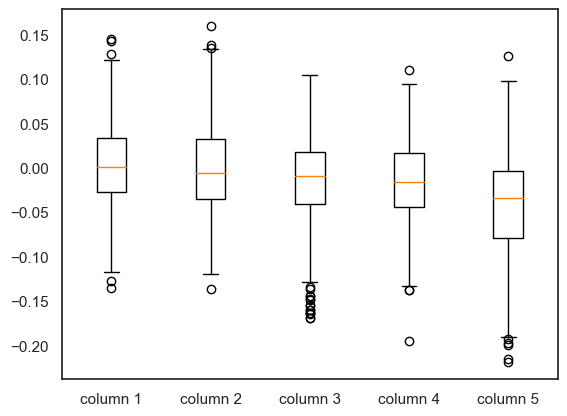

In [15]:
# lets simply plot 5 first columns (out of 384 columns) to visualize the distribution
# Create a figure and axes object
fig, ax = plt.subplots()

# Create the box plots
bp1 = ax.boxplot(embeddings[:,0], positions=[1], widths=0.3)
bp2 = ax.boxplot(embeddings[:,1], positions=[2], widths=0.3)
bp3 = ax.boxplot(embeddings[:,2], positions=[3], widths=0.3)
bp4 = ax.boxplot(embeddings[:,3], positions=[4], widths=0.3)
bp4 = ax.boxplot(embeddings[:,4], positions=[5], widths=0.3)

# Set the x-axis labels
ax.set_xticklabels(['column 1', 'column 2', 'column 3','column 4','column 5'])

# Show the plot
plt.show()

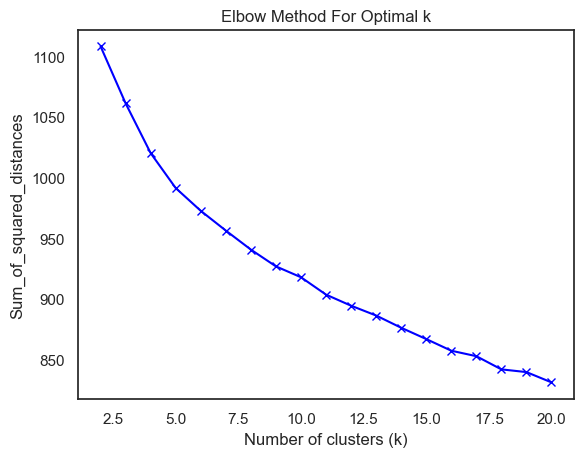

In [16]:
# simple elbow method

Sum_of_squared_distances = []

# range of possible k from 2 to 20
K = range(2,21)
for k in K:
    km = KMeans(n_clusters=k, max_iter=200, n_init=10)
    km = km.fit(embeddings)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()


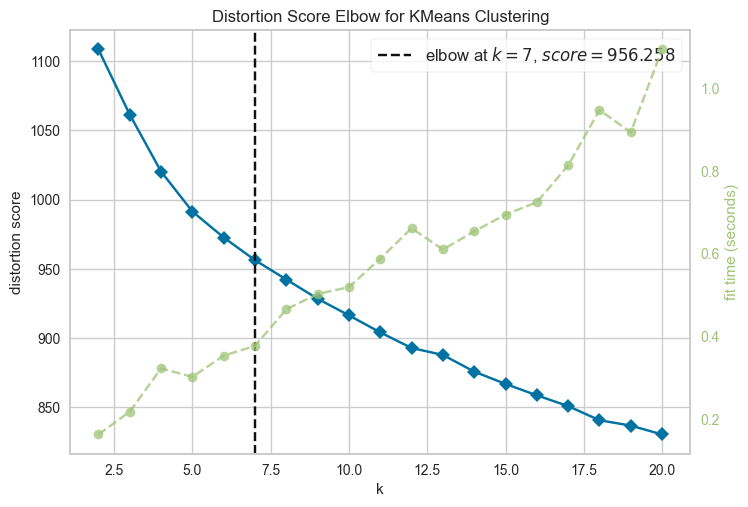

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [17]:
# Elbow Method for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,21), timings= True)
visualizer.fit(embeddings)    
visualizer.show()        

In [18]:
# we going append the best number of k into the list to reach our final desicion
optimal_Ks=[]

==> Silhouetter Score: 0.052


SilhouetteVisualizer(ax=<Axes: >, colors='yellowbrick',
                     estimator=KMeans(n_clusters=2, random_state=11))

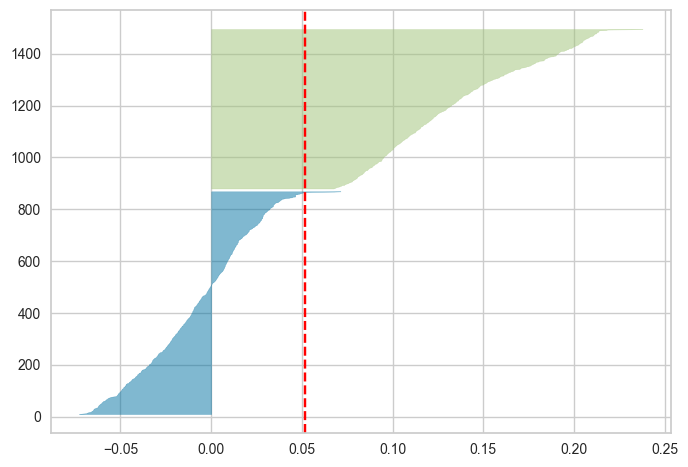

In [19]:
# Trying only two clusters with Silhouette

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

# Instantiate the KMeans models
km = KMeans(n_clusters=2, random_state=11)

# Fit the KMeans model
km.fit_predict(embeddings)

# Calculate Silhoutte Score
score = silhouette_score(embeddings, km.labels_, metric='euclidean')

# Print the score
print('==> Silhouetter Score: %.3f' % score)
SilhouetteVisualizer(km, colors='yellowbrick').fit(embeddings)

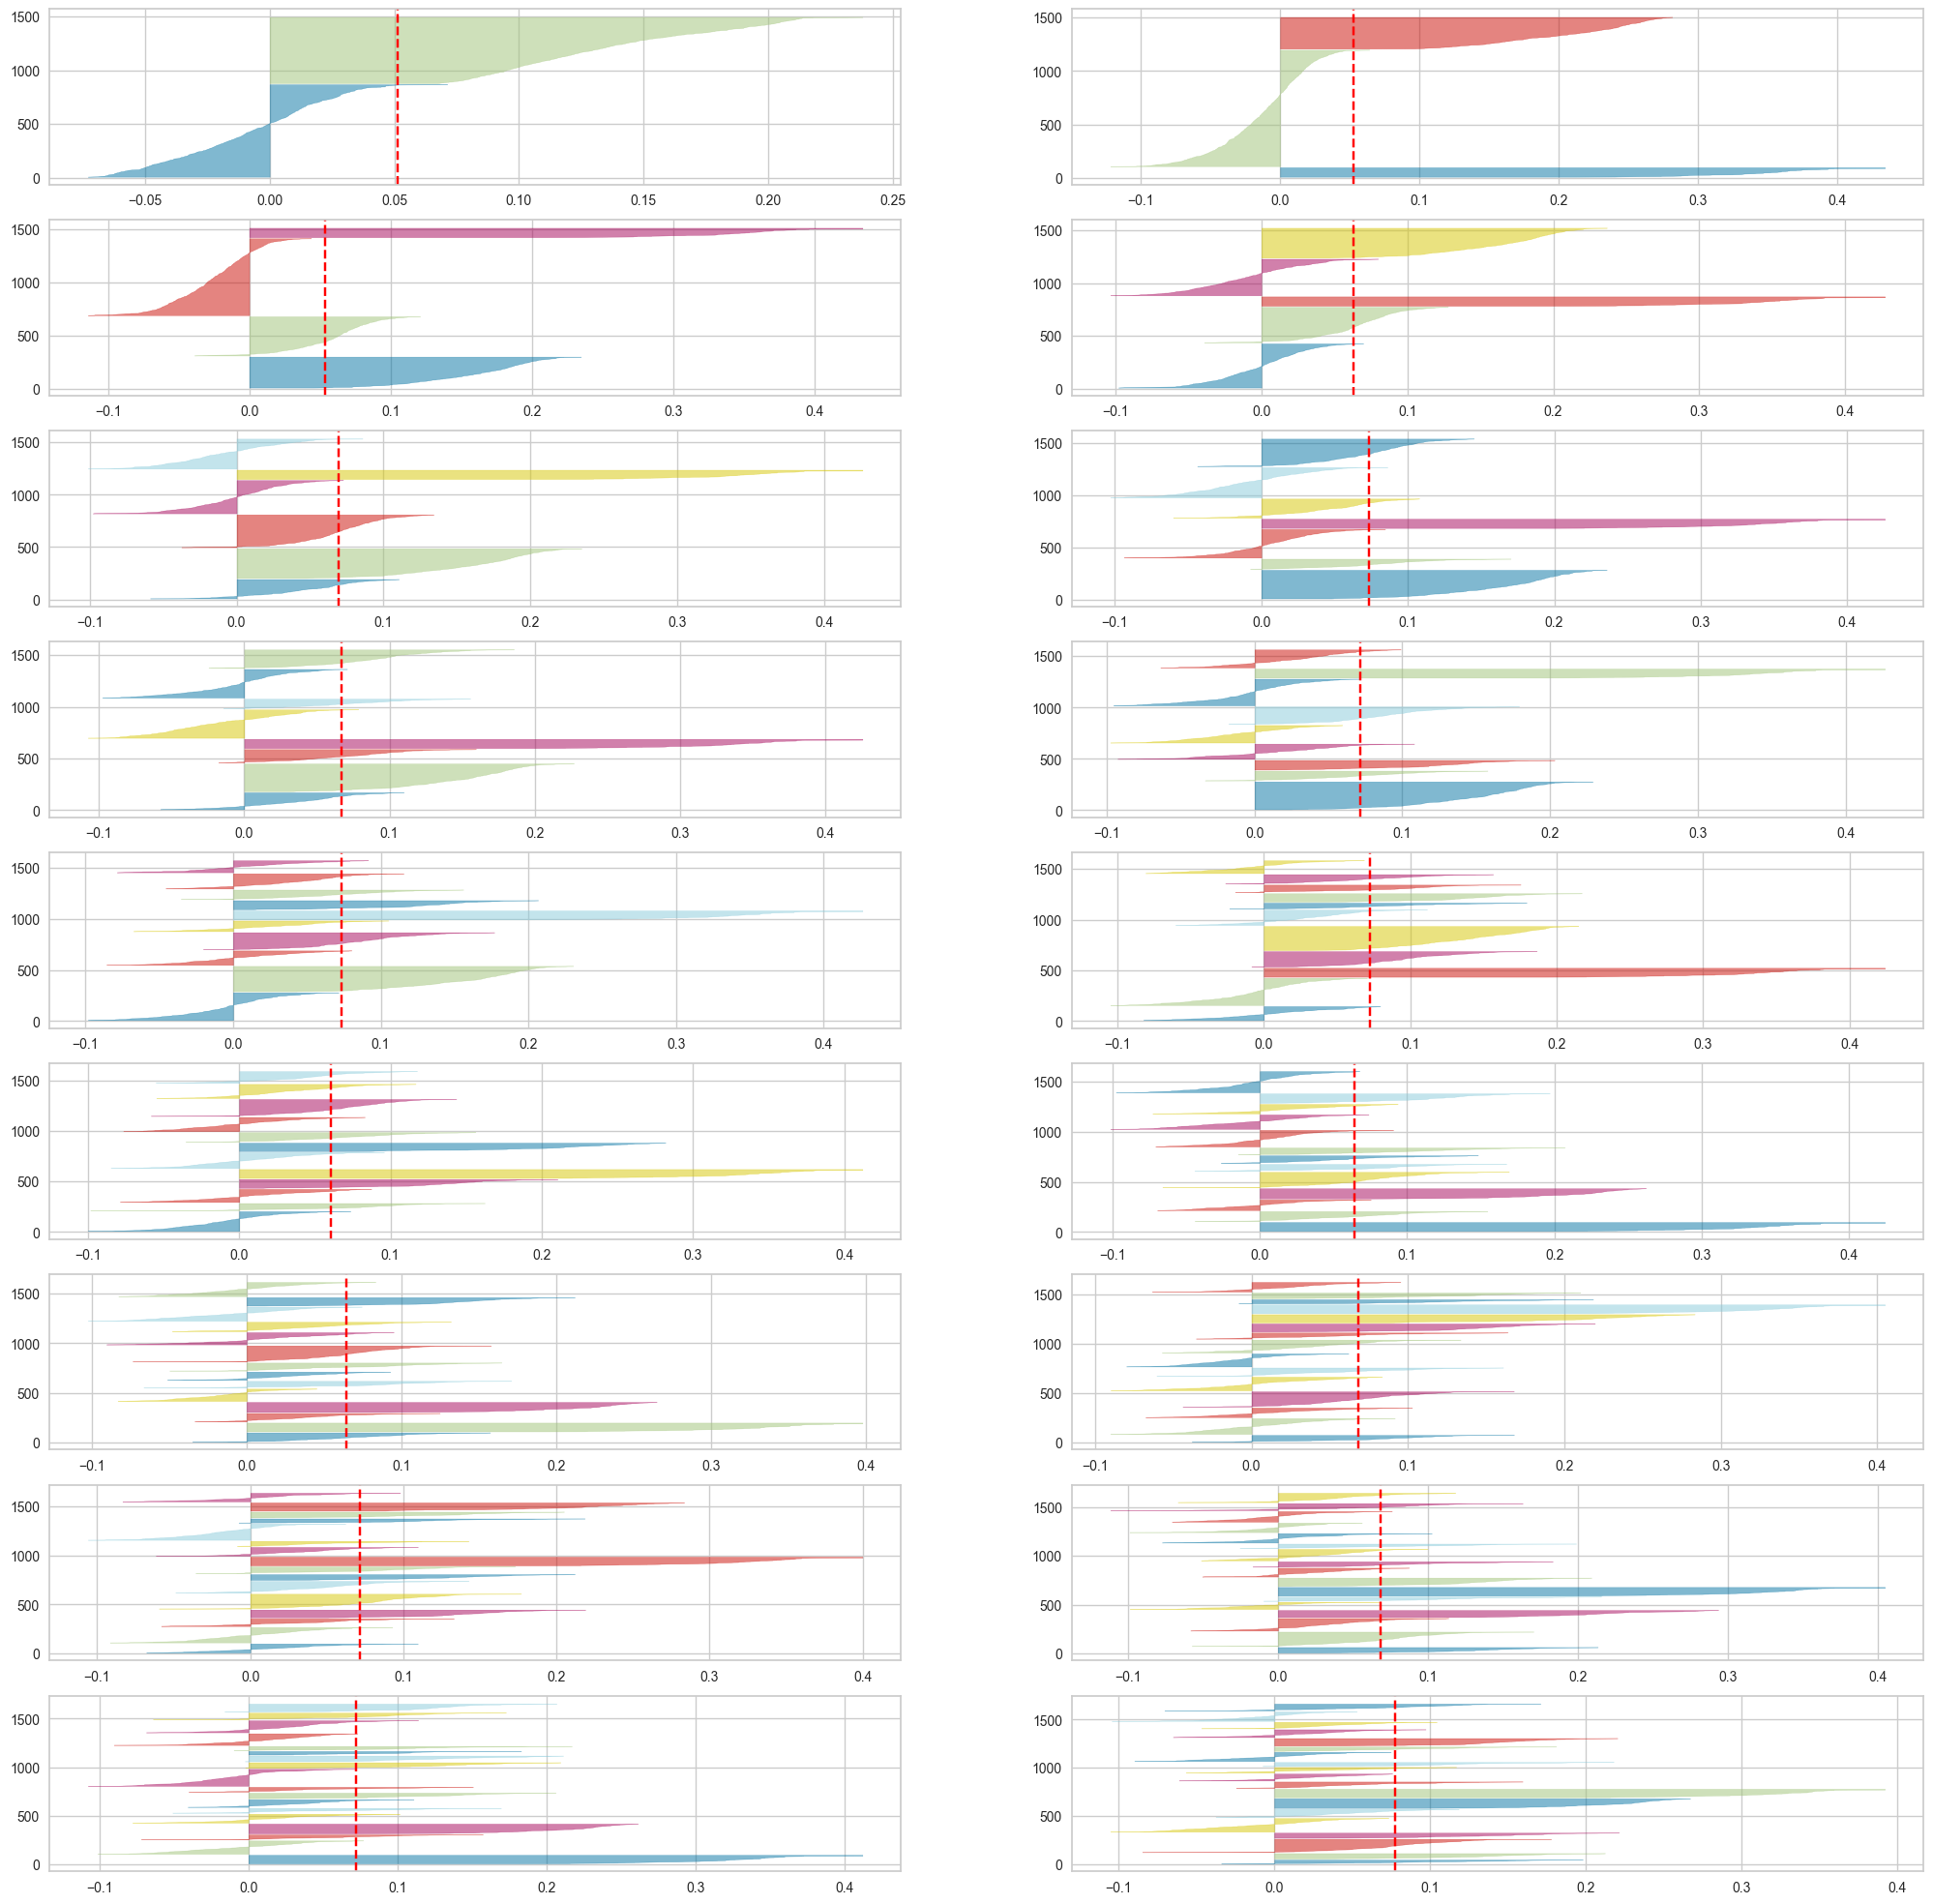

In [20]:
'''
This code loops through the range of number of clusters (2 to 20), 
at each iteration it creates an instance of KMeans algorithm with the number of clusters as i, and then it divides i by 2 and gets the quotient and remainder.
Then it creates an instance of SilhouetteVisualizer with the KMeans instance and set the color to yellowbrick and the ax parameter is set to ax[qou-1][rem].
Finally, it fits the visualizer with the embeddings.
'''
# Create a figure and set of subplots with 10 rows and 2 columns.
fig, ax = plt.subplots(nrows=9, ncols=2, figsize=(25, 25))

# Iterate through the range of number of clusters (2 to 20)
for i in range(2, 20):
    # Create a KMeans instance with the number of clusters as i
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=11)
    # Divide i by 2 and get the quotient and remainder
    quo, rem = divmod(i, 2)

    # Create an instance of SilhouetteVisualizer with the KMeans instance and set the color to yellowbrick
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[quo-1][rem])
    # Fit the visualizer with the embeddings
    visualizer.fit(embeddings)

In [21]:
from sklearn.metrics import silhouette_score

# Create a list of possible numbers of clusters to try
num_clusters = list(range(2, 20))

# Calculate the silhouette scores for each number of clusters
silhouette_scores = []
for k in num_clusters:
    # run clustering for each k
    kmeans = KMeans(n_clusters=k,n_init=10)
    kmeans.fit(embeddings)
    labels = kmeans.predict(embeddings)
    #calculating the sihouetter score
    sil_score=silhouette_score(embeddings,labels)
    print("cluster:",k,  "score -> ",  sil_score)
    silhouette_scores.append(sil_score)
    

# displaying the optimum number of clusters
optimal_num_clusters = num_clusters[silhouette_scores.index(max(silhouette_scores))]
print("The highest s-score of the k-clusters: " , optimal_num_clusters)

#appending the result into the opmimum list
optimal_Ks.append(optimal_num_clusters)

cluster: 2 score ->  0.051307317
cluster: 3 score ->  0.06387303
cluster: 4 score ->  0.053949784
cluster: 5 score ->  0.06306902
cluster: 6 score ->  0.0691821
cluster: 7 score ->  0.07323983
cluster: 8 score ->  0.0689683
cluster: 9 score ->  0.06691817
cluster: 10 score ->  0.07130978
cluster: 11 score ->  0.071869805
cluster: 12 score ->  0.060975216
cluster: 13 score ->  0.062873885
cluster: 14 score ->  0.06401977
cluster: 15 score ->  0.06922099
cluster: 16 score ->  0.07110158
cluster: 17 score ->  0.06957856
cluster: 18 score ->  0.07277783
cluster: 19 score ->  0.07556736
The highest s-score of the k-clusters:  19


In [22]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

# Create a list of possible numbers of clusters to try
num_clusters = list(range(2, 21))

# Calculate the silhouette scores for each number of clusters
dav_scores = []
for k in num_clusters:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(embeddings)
    labels = kmeans.predict(embeddings)
    
    # calculating Davies score for each k
    dav_score=davies_bouldin_score(embeddings, labels)
    print("cluster:",k,  "value -> ",  dav_score)
    dav_scores.append(dav_score)
    

# displaying the optimum number of clusters
optimal_num_clusters = num_clusters[dav_scores.index(min(dav_scores))]
print("The optimum score of the k-clusters: " , optimal_num_clusters)

#appending the result into the opmimum list
optimal_Ks.append(optimal_num_clusters)

cluster: 2 value ->  3.8999606709778987
cluster: 3 value ->  3.2711288681812216
cluster: 4 value ->  3.296439390249601
cluster: 5 value ->  3.479768836919402
cluster: 6 value ->  3.3873147163279413
cluster: 7 value ->  3.2673396795917227
cluster: 8 value ->  3.3557621518681
cluster: 9 value ->  3.1691021285857435
cluster: 10 value ->  3.1585796902119823
cluster: 11 value ->  3.2692414249260606
cluster: 12 value ->  3.245252490247372
cluster: 13 value ->  3.192020601824458
cluster: 14 value ->  3.0791582534736546
cluster: 15 value ->  3.2583121438487637
cluster: 16 value ->  3.161862452244948
cluster: 17 value ->  3.1242565214328875
cluster: 18 value ->  3.053411243934095
cluster: 19 value ->  3.0901226290747714
cluster: 20 value ->  2.9268463244526335
The optimum score of the k-clusters:  20


In [23]:
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score

# Create a list of possible numbers of clusters to try
num_clusters = list(range(2, 21))

# Calculate the silhouette scores for each number of clusters
cal_scores = []
for k in num_clusters:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(embeddings)
    labels = kmeans.predict(embeddings)
    
    # calculating Calinski index
    cal_score=calinski_harabasz_score(embeddings, labels)
    print("cluster:",k,  "value -> ",  cal_score)
    cal_scores.append(cal_score)
    

# displaying the optimum number of clusters
optimal_num_clusters = num_clusters[cal_scores.index(max(cal_scores))]
print("The optimum score of the k-clusters: " , optimal_num_clusters)

cluster: 2 value ->  90.82900889318425
cluster: 3 value ->  77.88228343106668
cluster: 4 value ->  75.21794366139298
cluster: 5 value ->  68.70434747523412
cluster: 6 value ->  61.64312597638789
cluster: 7 value ->  56.407437673348106
cluster: 8 value ->  52.65931648353339
cluster: 9 value ->  49.426044743569854
cluster: 10 value ->  46.88891245790687
cluster: 11 value ->  43.845240421422645
cluster: 12 value ->  42.28037255612532
cluster: 13 value ->  40.40746616869409
cluster: 14 value ->  38.79365028179084
cluster: 15 value ->  37.320809125913705
cluster: 16 value ->  36.27095209718039
cluster: 17 value ->  34.77239894101066
cluster: 18 value ->  34.050329684005234
cluster: 19 value ->  33.28197011377937
cluster: 20 value ->  31.965461203762928
The optimum score of the k-clusters:  2


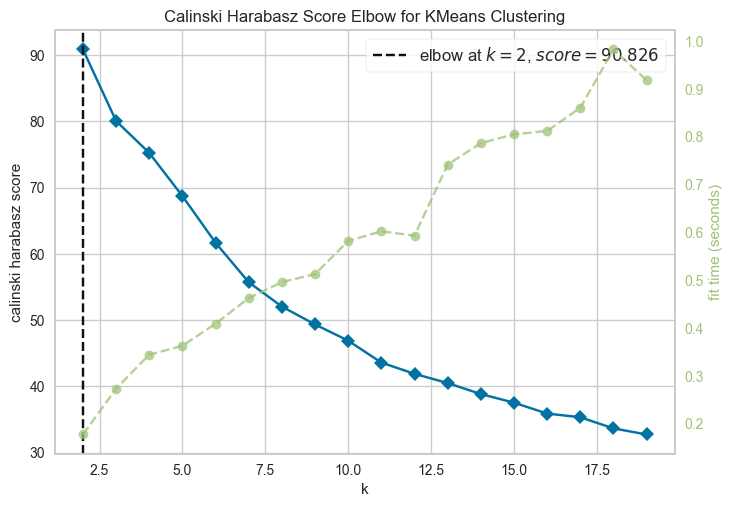

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [24]:
# Calinski Harabasz Score for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,20),metric='calinski_harabasz')
visualizer.fit(embeddings)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [25]:
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
import warnings
np.warnings = warnings


# Create an X-means object with the sample data
xmeans_instance = xmeans(embeddings, kmeans_plusplus_initializer(embeddings, 2).initialize())

# Perform the X-means algorithm
xmeans_instance.process()

# Get the optimal number of clusters
clusters = xmeans_instance.get_clusters()

# print the clusters
print('the identified optimum cluster ==> ',len(clusters))

#appending the result into the opmimum list
optimal_Ks.append(len(clusters))

the identified optimum cluster ==>  9


In [26]:
# lets vote the median of the suggested clusters
int(np.median(optimal_Ks))

19

In [27]:
#'How many clusters do you want to use? use utilze median to vote

# lets use median of the optimal number of clusters
true_k = int(np.median(optimal_Ks))
k_model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
k_model.fit(embeddings)

# the labels given by clusters
labels=k_model.labels_
labels

array([18, 18, 12, ...,  0,  3,  3])

In [28]:
data.shape

(1476, 3)

In [29]:
# adding the labels to the our original dataset
data['labels'] = pd.Categorical(labels)

data.head()

,Subject,Name,Description,labels
0,MATH,Abstract Algebra I,Isomorphism theorems for groups. Group actions...,18
1,MATH,Abstract Linear Algebra,Rigorous proof-oriented course in linear algeb...,18
2,CHEM,Accelerated Chemistry I,Lectures and discussions. Beginning chemistry ...,12
3,CHEM,Accelerated Chemistry Lab I,Companion laboratory course to CHEM 202. Compr...,12
4,CS,Accelerated Fundamentals of Algorithms I,The first class in a sequence of two classes t...,7


In [30]:
# data.groupby(['labels','Subject']).size(): this groups the data by two columns 'labels' and 'Subject' and then it counts the number of occurances in each group.
# .unstack() : this unstacks the DataFrame, which means it pivots the dataframe from long format to wide format.
data_wide = data.groupby(['labels','Subject']).size().to_frame().unstack()
data_wide

0                                                                \
Subject ANTH BADM CEE CHEM CHLH CLE  CS ECE ENGL FIN FSHN  IS KIN MATH MUS   
labels                                                                       
0          2    0   0    0    0   0   0   0   37   0    0   1   0    0   1   
1          0   53   0    0    2   0   1   1    0   2    5   0   1    0   0   
2          1    0   0    0    0   0   0   0    0   0    0   0   0    0   0   
3          1    2   3    0    2   0   8   2    1   0    0  60   1    0   1   
4          2    8   4    1    5   0   6  12   14   6    6  10   5   11   2   
5          5    2   1    4    7   0  11  14    9   0    4   1   4    6   0   
6          0    0   0    0    0   0   0   1    0   0    0   0   0    0  98   
7          0   11   1    0    0   0  52  11    0   2    0  20   0    1   1   
8          0    0   0    0    0   0   0   0    0  55    0   0   0    0   0   
9          0    0  45    1    0   0   5  54    0   0    0   0   0    0   0   
10         0    0   0    0    1   0   0   0    0   0    0   1  33    0   0   
11         0    0   0    0    3   0   0   0    0   0    0   0   0    0   0   
12         0    0   2   52    0   0   0   3    0   0    0   0   0    0   0   
13         1    0   0    0   36   1   0   0    0   1    1   0  11    0   0   
14         0    0   0    0    0   0   0   0    0   0   41   0   1    0   0   
15        40    0   0    0    0   0   0   0    1   0    0   1   0    0   0   
16         0    0   0    0    0  74   0   0    0   0    0   0   0    0   0   
17         0    0   0    0    0   0   1   0    0   0    0   1   0    0   3   
18         0    1   0    0    0   0   3   2    0   0    0   0   0   55   1   

                                
Subject MUSC  PS PSYC RST THEA  
labels                          
0          0   0    0   0    1  
1          0   0    0  14    0  
2          0  44    0   0    0  
3          0   1    1   0    2  
4          0   4   14   5    6  
5          0   4   10   5    2  
6        136   0    0   0    0  
7          0   0    0   0    0  
8          0   0    0   1    0  
9          0   0    0   0    1  
10         0   0    0  26    0  
11         0   1   40   0    0  
12         0   0    0   0    0  
13         0   0    9   0    0  
14         0   0    0   0    0  
15         0   1    0   1    0  
16         0   0    0   0    0  
17         2   0    0   0   68  
18         0   0    0   0    0

In [31]:
embeddings.shape

(1476, 384)

In [32]:
#reduce the dimension of data into two and then plot it
from sklearn.manifold import TSNE
X_embedded_2d = TSNE(n_components=2).fit_transform(embeddings)

In [33]:
data

,Subject,Name,Description,labels
0,MATH,Abstract Algebra I,Isomorphism theorems for groups. Group actions...,18
1,MATH,Abstract Linear Algebra,Rigorous proof-oriented course in linear algeb...,18
2,CHEM,Accelerated Chemistry I,Lectures and discussions. Beginning chemistry ...,12
3,CHEM,Accelerated Chemistry Lab I,Companion laboratory course to CHEM 202. Compr...,12
4,CS,Accelerated Fundamentals of Algorithms I,The first class in a sequence of two classes t...,7
...,...,...,...,...
1471,ENGL,Writing Studies,Reviews theory and research on the social and ...,0
1472,ENGL,Writing Technologies,Examines the relationship of computer technolo...,3
1473,ENGL,"Writing about Literature, Text, and Culture","Writing-intensive, variable-topic course desig...",0
1474,IS,Youth Services Librarianship,"Theory and techniques in planning, implementin...",3


In [35]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import texthero as hero

# Assuming 'data' is your original DataFrame and 'embeddings' is the numpy array of shape (1476, 384)
data_hero = data.copy()

# Ensure 'embeddings' is a numpy array
embeddings_array = np.array(embeddings)

# Apply TSNE from sklearn to reduce dimensions
tsne_model = TSNE(n_components=2, random_state=42)
tsne_results = tsne_model.fit_transform(embeddings_array)

# Add TSNE results to the DataFrame
data_hero['tsne_x'] = tsne_results[:, 0]
data_hero['tsne_y'] = tsne_results[:, 1]

# Combine the x and y columns into a single column of lists
data_hero['tsnemodel'] = data_hero[['tsne_x', 'tsne_y']].values.tolist()

# Check if the transformation worked correctly
print(data_hero[['tsne_x', 'tsne_y', 'tsnemodel']].head())

# Plot the data using texthero's scatterplot
hero.scatterplot(data_hero, col='tsnemodel',
                 color='labels',
                 title="Course categories",
                 hover_data=['Subject', 'Name'])


      tsne_x     tsne_y                                tsnemodel
0  24.239611  34.209488   [24.23961067199707, 34.20948791503906]
1  13.585744  34.169598   [13.58574390411377, 34.16959762573242]
2 -41.849243   4.510248   [-41.8492431640625, 4.510247707366943]
3 -39.517628   4.736292  [-39.51762771606445, 4.736291885375977]
4   5.012966  26.881420  [5.012966156005859, 26.881420135498047]


[Text(0.5, 1.0, 'Course data T-SNE projection')]

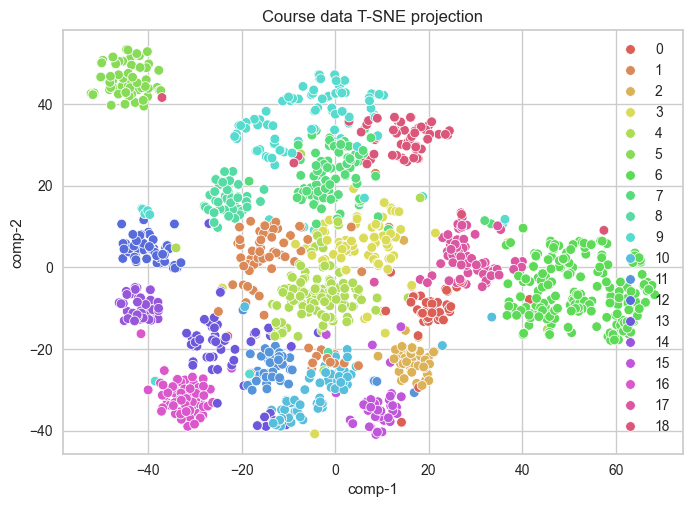

In [36]:

# Using sns package to plot the data
df_2d = pd.DataFrame()
df_2d["y"] = labels
df_2d["comp-1"] = X_embedded_2d[:,0]
df_2d["comp-2"] = X_embedded_2d[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df_2d.y.tolist(),
                palette=sns.color_palette("hls", true_k),
                data=df_2d).set(title="Course data T-SNE projection")


In [37]:
# reduce the dimention to 3 for 3d plotting
X_embedded_3d = TSNE(n_components=3).fit_transform(embeddings)

In [38]:
import plotly.graph_objects as go  #for 3D plot
txt=[["Subject: " + data['Subject'][i], "Lables: " + str(data['labels'][i])] for i in range(len(data))]  

trace = go.Scatter3d(x=X_embedded_3d[:,0], y=X_embedded_3d[:,1], z=X_embedded_3d[:,2], 
                     mode='markers',
                     text=txt,
                     marker=dict(color = labels, size= 10, line=dict(color= 'black',width = 10)))
layout = go.Layout(margin=dict(l=0,r=0),height = 800,width = 800)
trace = [trace]
fig = go.Figure(data = trace, layout = layout)
fig.show()

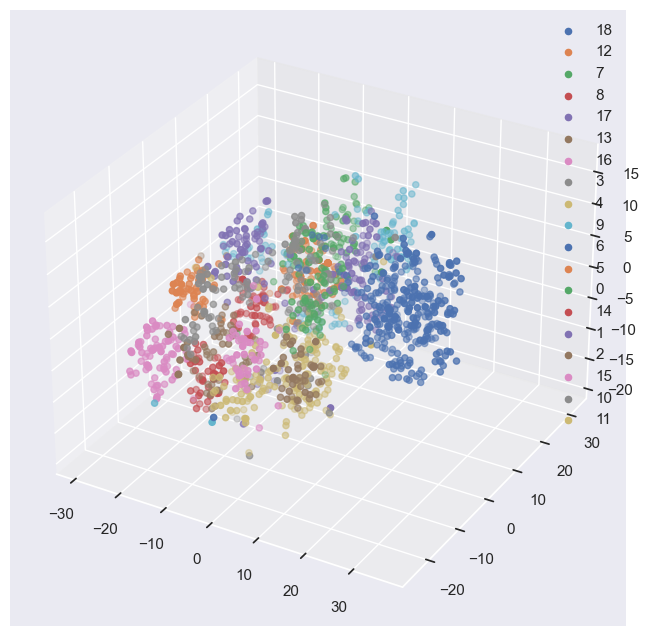

In [39]:
# plotting simple 3D plot

from mpl_toolkits.mplot3d import Axes3D

sns.set(style = "darkgrid")
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 8,8

#prepare a dataset for plotting
df_3d = pd.DataFrame()
df_3d["y"] = labels
df_3d["comp1"] = X_embedded_3d[:,0]
df_3d["comp2"] = X_embedded_3d[:,1]
df_3d["comp3"] = X_embedded_3d[:,2]


fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

# loop through labels of the clusters
for l in df_3d.y.unique():
    ax.scatter(df_3d.comp1[df_3d.y==l],df_3d.comp2[df_3d.y==l],df_3d.comp3[df_3d.y==l],label=l)
    
ax.legend()
plt.show()

In [40]:
import nmslib
model_index = nmslib.init(method='hnsw', space='cosinesimil')

In [41]:
model_index.addDataPointBatch(embeddings)

1476

In [42]:
model_index.createIndex({'post': 2})

In [43]:
def find_best_course(data, q_input):
    # Check if both inputs are not None
    if data is not None and q_input is not None:
        subset = data.copy()
        # Encode the q_input using the SBERT model
        query = model_SBERT.encode([q_input], convert_to_tensor=True)
        # Use the knnQuery function to find the 20 nearest neighbors to the encoded query
        ids, distances = model_index.knnQuery(query, k=20)
        
    # Initialize an empty list to store the best fits
    best_fits = []
    # Iterate through the returned ids and distances
    for i, j in zip(ids, distances):
        # Create a dictionary for each best fit containing information from the original data
        # Subject, Name, Description, cluster and distance returned by the knnQuery function
        best_fits.append({'Subject':subset.Subject.values[i]
                        , 'Name' : subset.Name.values[i]
                        , 'Description': subset.Description.values[i]
                        , 'Cluster': subset.labels.values[i]
                        , 'Distance': j
                       })
    return pd.DataFrame(best_fits)

In [45]:
most_similar=find_best_course(data, "Mathematics")

# exteract the most similar cluster
most_similar[most_similar['Cluster']==int(most_similar['Cluster'].mode())]

,Subject,Name,Description,Cluster,Distance
0,MATH,Elementary Mathematics,Analyses of the mathematical issues and method...,18,0.435579
1,MATH,Theory of Arithmetic,Analyses of the mathematical issues and method...,18,0.438885
5,MATH,Thinking Mathematically,Designed for students in majors that do not sp...,18,0.469045
6,MATH,Basic Discrete Mathematics,"Beginning course on discrete mathematics, incl...",18,0.490766
7,MATH,Finite Mathematics,Introduction to finite mathematics for student...,18,0.493390
8,MATH,Fundamental Mathematics,Fundamental ideas used in many areas of mathem...,18,0.498324
9,MATH,Calculus I,First course in calculus and analytic geometry...,18,0.544343
11,MATH,Calculus,First course in calculus and analytic geometry...,18,0.565355
12,MATH,Real Variables,Careful development of elementary real analysi...,18,0.568491
14,MATH,Vector and Tensor Analysis,Introductory course in modern differential geo...,18,0.573310
